In [1]:
# Primary Libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re

# text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# download required vocabs 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/sameep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sameep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sameep/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# global variables
warnings.filterwarnings("ignore")
COLORS = ['r', 'g', 'b', 'y']
COLUMNS = ['id', 'company', 'sentiment', 'tweet']

In [3]:
X_train = pd.read_csv("./Dataset/twitter_training.csv", names=COLUMNS, header=None)
X_test = pd.read_csv("./Dataset/twitter_validation.csv", names=COLUMNS, header=None)

# drop "id"
X_train.drop('id', axis = 1, inplace = True)
X_test.drop('id', axis = 1, inplace = True)

X_train.head(), X_train.shape

(       company sentiment                                              tweet
 0  Borderlands  Positive  im getting on borderlands and i will murder yo...
 1  Borderlands  Positive  I am coming to the borders and I will kill you...
 2  Borderlands  Positive  im getting on borderlands and i will kill you ...
 3  Borderlands  Positive  im coming on borderlands and i will murder you...
 4  Borderlands  Positive  im getting on borderlands 2 and i will murder ...,
 (74682, 3))

In [4]:
class Preprocess_tweets:
    def __init__(self, X):
        self.X = X
    
    def remove_null(self):
        for col in self.X.columns:
            if(self.X[col].isnull().sum() > 0):
                if(col == 'company'):
                    self.X[col].fillna('Others', inplace=True)
                else:
                    self.X.dropna(inplace=True)
    
    def remove_user_mentions(self):
        no_user_mentions = []
        cleaned_tweets = []
        for index in range(self.X.shape[0]):
            tweet = self.X['tweet'].iloc[index]
            no_user_mentions.append(re.sub(r'@[A-Za-z0-9]+', '', tweet))
            cleaned_tweets.append(re.sub('#', '', no_user_mentions[index]))

        self.X['cleaned_tweets'] = np.array(cleaned_tweets)
        self.X.drop('tweet', axis = 1, inplace = True)
    
    def convert_text(self):
        cleaned_tweets = []
        for index in range(self.X.shape[0]):
            tweet = self.X['cleaned_tweets'].iloc[index]
            
            # remove numbers (if any)
            tweet = re.sub(r'[^a-z A-Z]', '', tweet)
            
            # convert to lower case
            tweet = tweet.lower()
        
            cleaned_tweets.append(tweet)

        self.X['cleaned_tweets'] = np.array(cleaned_tweets)

    def unique_words(self):
        unique_words = []
        for index in range(self.X.shape[0]):
            dict = {}
            temp = []
            tweet = self.X['cleaned_tweets'].iloc[index]

            word_tokens = tweet.split()

            for word in word_tokens:
                if word not in dict:
                    temp.append(word)
                    dict.update({word: 1})
                else:
                    dict[word] += 1
            
            unique_words.append(" ".join(temp).strip())
        
        self.X['cleaned_tweets'] = np.array(unique_words)

    def zero_len_remove_null(self):
        word_count = []
        outlier_tweets = []
        zero_length_count = 0
        for index in range(self.X.shape[0]):
            word_count.append(len(self.X['cleaned_tweets'].iloc[index].split()))
            if(word_count[index] == 0):
                zero_length_count += 1
                self.X['cleaned_tweets'].iloc[index] = np.nan
            if(word_count[index] > 30):
                outlier_tweets.append((self.X['sentiment'].iloc[index], self.X['cleaned_tweets'].iloc[index]))
        self.X.dropna(inplace=True)
        return self.X, outlier_tweets, word_count
    
    def stem_and_lemmatize(self):
        cleaned_tweets = []
        lemmatizer = WordNetLemmatizer()
        ps = PorterStemmer()
        for index in range(self.X.shape[0]):
            tweet = self.X['cleaned_tweets'].iloc[index]

            # tokenize tweet
            word_tokens = tweet.split()

            # remove stop words
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

            # first stem and then lemmatize
            for count, word in enumerate(filtered_sentence):
                temp = ps.stem(word)
                filtered_sentence[count] = lemmatizer.lemmatize(temp)

            # rejoin to form sentence
            filtered_sentence = " ".join(filtered_sentence).strip()
            cleaned_tweets.append(filtered_sentence)

        self.X['cleaned_tweets'] = np.array(cleaned_tweets)
        # return self.X

In [5]:
# preprocess training dataset
process_train = Preprocess_tweets(X_train)
process_train.remove_null()
process_train.remove_user_mentions()
process_train.convert_text()
process_train.unique_words()
process_train.stem_and_lemmatize()
X_train, outlier_tweets, word_count = process_train.zero_len_remove_null()
X_train.head()

,company,sentiment,cleaned_tweets
0,Borderlands,Positive,im get borderland murder
1,Borderlands,Positive,come border kill
2,Borderlands,Positive,im get borderland kill
3,Borderlands,Positive,im come borderland murder
4,Borderlands,Positive,im get borderland murder


In [6]:
# preprocess test dataset
process_test = Preprocess_tweets(X_test)
process_test.remove_null()
process_test.remove_user_mentions()
process_test.convert_text()
process_test.unique_words()
process_test.stem_and_lemmatize()
X_test, outlier_tweets_test, word_count_test = process_test.zero_len_remove_null()
X_test.head()

,company,sentiment,cleaned_tweets
0,Facebook,Irrelevant,mention facebook struggl motiv go run day tran...
1,Amazon,Neutral,bbc news amazon bos jeff bezo reject claim com...
2,Microsoft,Negative,pay word function poorli chromebook
3,CS-GO,Negative,csgo matchmak full closet hack truli aw game
4,Google,Neutral,presid slap american face realli commit unlaw ...


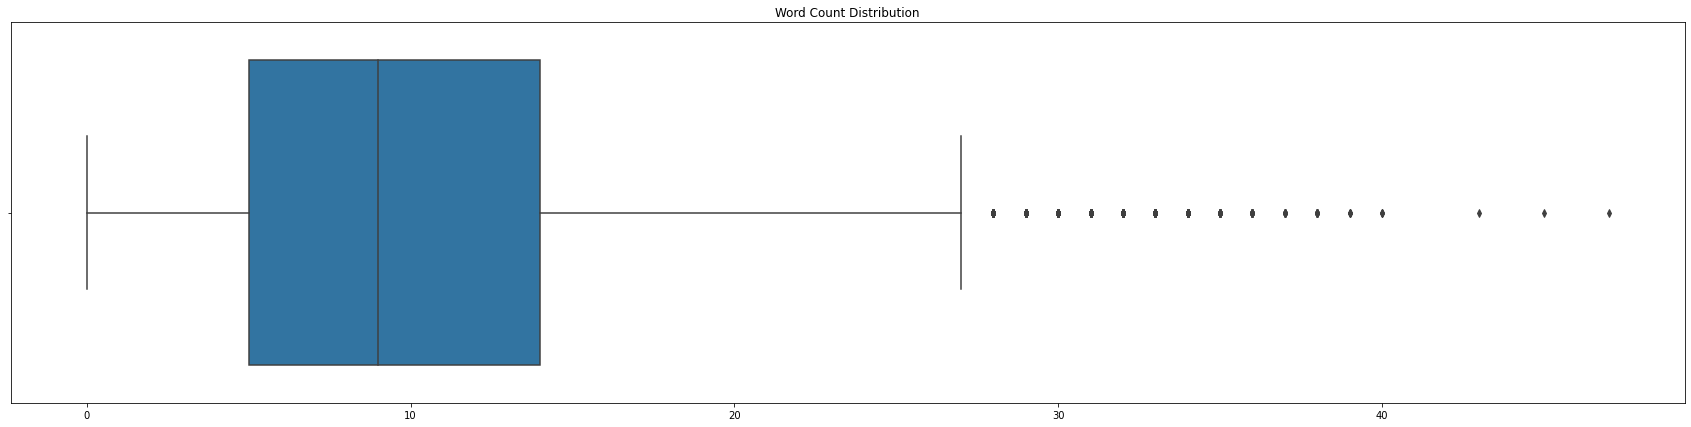

In [7]:
plt.figure(figsize=(30, 7))

sns.boxplot(np.array(word_count))
plt.title("Word Count Distribution")
plt.show()

In [8]:
X_train.to_csv("./Dataset/cleaned_training.csv")
X_test.to_csv('./Dataset/cleaned_test.csv')